Set-ExecutionPolicy Unrestricted -Scope Process  
NN/Scripts/Activate.ps1 
python -m pip install matplotlib

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train_matrix, y_train), (x_test_matrix, y_test) = mnist.load_data()

I dati sono in formato di matrice, ma noi lavoreremo con il vettore dei pixel, è quindi necessario prima appiattire tutte le matrici.

In [ ]:
x_train = np.array([x_train[i].reshape(-1) for i in range(len(x_train_matrix))])
x_test = np.array([x_test[i].reshape(-1) for i in range(len(x_test_matrix))])

Convertire il tutto in pandas.DataFrame per visualizzare 

In [5]:
df_x = pd.DataFrame(x_train)
df_x['label'] = y_train
df_x.columns = [f'pixel_{i}' for i in range(784)] + ['label']
df_x.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


Unisco y_train e x_train per mischiare allo stesso modo i dati. Successivamente li divido in training e validation

In [6]:
y_train = y_train.reshape(-1,1)
data =  np.concatenate((y_train, x_train), axis=1)
np.random.shuffle(data)

data_val = data[0:10000].T
Y_val = data_val[0]
X_val = data_val[1:] / 255

data_train = data[10000:].T
Y_train = data_train[0]
X_train = data_train[1:] /255

In [17]:
X_test = x_test.T / 255
Y_test = y_test.T

Creiamo ora la funzione che verrà utilizzata per inizializzare i pesi e il bias della rete neurale

In [138]:
def init_params(size_first_hl = 10):
    W1 = np.random.rand(size_first_hl, 784) - 0.5
    b1 = np.random.rand(size_first_hl, 1) - 0.5
    
    W2 = np.random.rand(10, size_first_hl) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2

In [8]:
def ReLU(Z):
    # This will be applied to each element of Z
    return np.maximum(0, Z)

def softmax(Z):
    e_x = np.exp(Z - np.max(Z))
    return e_x / e_x.sum(axis=0)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max() + 1)))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(Z):
    return Z>0

In [56]:
def forward_prop(X, W1, b1, W2, b2):
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    
    if A1.ndim == 1:
        A1 = A1.reshape(-1, 1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [141]:
def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1/ m * dZ2.sum(axis=1)
    db2 = db2.reshape(-1,1)
    
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1/ m * dZ1.sum(axis=1)
    db1 = db1.reshape(-1,1)
    
    return dW1, dW2, db1, db2

In [11]:
def update_param(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha = 0.5):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    
    return W1, b1, W2, b2

In [147]:
def get_predictions(A):
    return np.argmax(A, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, X_val, Y_val, iterations = 1, alpha = 0.5, size_first_hl = 10):
    accuracy = []
    val_accuracy = []
    stop_warnings = 0
    
    W1, b1, W2, b2 = init_params(size_first_hl = size_first_hl)
    W1_final = W1
    b1_final = b1
    W2_final = W2
    b2_final = b2
    final_version = 0
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(X, W1, b1, W2, b2)
        dW1, dW2, db1, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_param(W1, b1, W2, b2, dW1, dW2, db1, db2, alpha = alpha)
        
        accuracy.append(get_accuracy(get_predictions(A2), Y))
        
        Z1_val, A1_val, Z2_val, A2_val = forward_prop(X_val, W1, b1, W2, b2)
        val_accuracy.append(get_accuracy(get_predictions(A2_val), Y_val))
        
        if len(val_accuracy)>2 and val_accuracy[-1] < val_accuracy[-2]:
            stop_warnings +=1
        else:
            W1_final = W1
            b1_final = b1
            W2_final = W2
            b2_final = b2
            final_version = i
            stop_warnings = 0
            
        if stop_warnings >= 50:
            break
        
        if i % 10 == 0:
            print(f'Iteration {i}')
            print(f'Accuracy : {accuracy[-1]}')
    
    plt.plot(accuracy, color='r', label='Training Accuracy')
    plt.plot(val_accuracy, color='g', label='Validation Accuracy')
    plt.axvline(x = final_version, color = 'b', linestyle = '--')
    
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation comparation")
    
    plt.legend()
    
    plt.show()
    
    print(f'Training finished in {i+1} iterations')       
    print(f'Final Accuracy : {accuracy[-1]}')        
    
    return W1_final, b1_final, W2_final, b2_final

In [144]:
W1, b1, W2, b2 = init_params(size_first_hl = 15)

In [148]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, X_val, Y_val,iterations = 5000, alpha = 0.2, size_first_hl = 15)

Iteration 0
Accuracy : 0.06246
Iteration 10
Accuracy : 0.28352
Iteration 20
Accuracy : 0.44052
Iteration 30
Accuracy : 0.54308
Iteration 40
Accuracy : 0.60968


KeyboardInterrupt: 

## Testing

In [125]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [126]:
Z1, A1, Z2, A2 = forward_prop(X_test, W1, b1, W2, b2)
predicted = get_predictions(A2)
print(f'Accuracy : {get_accuracy(predicted, Y_test)}')

Accuracy : 0.9312


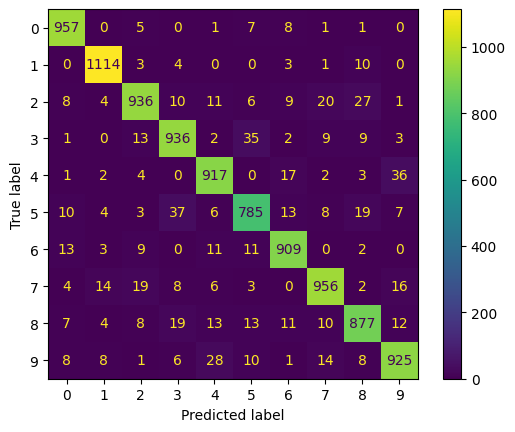

In [130]:
conf_matrix = confusion_matrix(Y_test, predicted)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

## Show results

In [83]:
def show_results(W1, b1, W2, b2, X_test, i = -1):
    if i <0 or i>len(X_test):
        i = int(np.random.uniform( low = 0.0, high = len(X_test)))
    Z1, A1, Z2, A2 = forward_prop(X_test[:,i], W1, b1, W2, b2)
    plt.imshow(x_test_matrix[i], cmap='Greys',  interpolation='nearest')
    plt.suptitle(f'Real value: {y_test[i]}')
    plt.title(f'Predicted value: {np.argmax(A2)}')

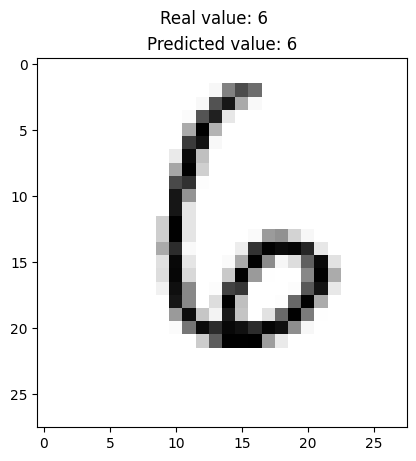

In [123]:
show_results(W1, b1, W2, b2, X_test)

Next steps: 
- fare in modo che la rete neurale sia modificabile anche in lunghezza
- plot dei grafici riguardanti le performance di varie strutture di grafici 